# Efficient Similarity Search    

## CSCI E-108      

### Steve Elston

In these exercises you will gain some experience with methods for efficient similarity search. A naive similarity search requires a brute-force computation of all pairwise distances, in the chosen metrics. The brute-force approach is not scalable with computational complexity for $n$ observations is $O(n^2)$. For massive dataset we need much more efficient methods. Here, we will explore two possibilities:        
1. [**KD trees**](https://en.wikipedia.org/wiki/K-d_tree) are constructed from recurrsive binary splits. For a dataset with $n$ observatrions and dimensionality, $d$, the computational complexity is $O\big(d\ n \log(n) \big)$. While not ideal linear scaling, $O(n)$,the KD tree is a significant improvement over brute-force methods. Generally, KD-trees are considered to be efficient for large datasets with $d \le 20$. For higher dimensional data, R-trees and ball trees can be extended to higher dimensional data. We will apply ball trees for clustering and dimensionality reduction with the spectral clustering and UMAP algorithms.     
2. [**Mini-hashing**](https://en.wikipedia.org/wiki/MinHash) and [**locally sensitive hashing (LSH)**](https://en.wikipedia.org/wiki/Locality-sensitive_hashing#:~:text=In%20computer%20science%2C%20locality%2Dsensitive,universe%20of%20possible%20input%20items.)) can be applied to massive very high dimensional dataset. The mini-hash algorithm creates sketches of the observations that approximate the Jacard similarity between two varaibles. Multiple bands of sketches are combined to create locally sensive hashes with lower false positive and false negative rates.     

Before proceeding to the exercises, execute the code in the cell below to import the required packages.  

In [1]:
import os
import time
import itertools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split
import math

## Similarity Search with KD Trees     

We will now explore a basic example of using a KD tree to find nearest neighbors. We will use a small (toy) dataset of characteristics and metabolic measurements taken from 442 diabetes patients. The KD tree algorithm will be used to find the nearest neightbors of the patients, based on the Euclidean distrance between the observation vectors.    

### Load the dataset

The diabetes dataset is in the [Scikit Learn Datasets package](https://scikit-learn.org/stable/api/sklearn.datasets.html).This dataset has already been clearned, missing values dealt with, and standardized (zero mean, unite variance). Therefore, we will skip the usual exploration and preparation steps.     

Execute the code in the cell below to load the dataset and split it into two data frames, one for training and one for test.  

In [2]:
train_size = 20
column_names = ['age_years',
                'sex',
                'BMI',
                'Average_BP',
                'serum_cholesterol',
                'LDL',
                'HDL',
                'total_chol_over_HDL',
                'log_serum_triglycerides',
                'Glucose_level']

diabetes_test, diabetes_train = train_test_split(datasets.load_diabetes()['data'], train_size=train_size)

diabetes_train = pd.DataFrame(diabetes_train, columns=column_names)
diabetes_test = pd.DataFrame(diabetes_test, columns=column_names)
print('Dimensions of training data frame = ' + str(diabetes_train.shape))
print(diabetes_test)

Dimensions of training data frame = (422, 10)
    age_years       sex       BMI  Average_BP  serum_cholesterol       LDL  \
0   -0.034575  0.050680 -0.025607   -0.017135           0.001183 -0.002880   
1    0.009016  0.050680 -0.005128   -0.064199           0.069981  0.083863   
2   -0.060003  0.050680  0.015350   -0.019442           0.036958  0.048164   
3   -0.001882 -0.044642 -0.038540    0.021872          -0.108893 -0.115613   
4   -0.052738  0.050680  0.098342    0.087287           0.060349  0.048790   
5    0.016281  0.050680  0.072474    0.076958          -0.008449  0.005575   
6    0.063504  0.050680  0.088642    0.070072           0.020446  0.037517   
7    0.045341 -0.044642 -0.006206    0.011544           0.063101  0.016222   
8   -0.052738 -0.044642  0.030440   -0.074527          -0.023584 -0.011335   
9    0.041708 -0.044642 -0.045007    0.034508           0.043837 -0.015719   
10   0.074401 -0.044642  0.018584    0.063187           0.061725  0.042840   
11  -0.092695  0.0

Notice that each of the observations is a numeric vector with 10 variables. These variables have all be standardized.    

### Constructing and querying the KD-Tree   

The code in the cell below constructs the KD-tree as a KD-tree object with the required arguments. Execute the code. 

In [3]:
%time KD_tree = KDTree(diabetes_train, leaf_size=10, metric='euclidean') 

CPU times: user 479 μs, sys: 104 μs, total: 583 μs
Wall time: 508 μs


Notice how quickly the tree was constructed. This should not be surprising given the small data set and low dimensionality of the data.   

With the tree constructed we can now query the tree with the test data. The number of near neighbors is specified as 1 so that the query returns the single nearest neighbors.    

> **Note:** In this case we are interested in similarity with each of the observations used to construct the KD-tree, so we use $k=1$ nearest neighbors. For other purposes, such as constructing a nearest neighbor graph, a larger value of $k$ is used. We will encounter a number algorithms using nearest neighbor graphs in subsequent lessons.   

In [4]:
np.random.seed(4545)
%time distances, neighbors = KD_tree.query(diabetes_test, k=1)
distance_frame = pd.DataFrame({'Nearest Neighbor':neighbors.ravel(), 'Distance':distances.ravel()})
distance_frame.sort_values('Distance')

CPU times: user 485 μs, sys: 91 μs, total: 576 μs
Wall time: 464 μs


,Nearest Neighbor,Distance
16,353,0.046392
0,288,0.046689
8,5,0.050318
14,191,0.057438
18,39,0.057763
10,354,0.060016
15,191,0.060160
7,404,0.060841
13,154,0.064873
5,58,0.066482


Next print some summary statistics for the 20 queries just performed on the KD-tree by executing the code in the cell below.  

In [5]:
print("Stats for the tree")
print("Number of trims = %5d \nnumber of leaves = %5d \nnumber of splits = %6d" % KD_tree.get_tree_stats())

Stats for the tree
Number of trims =   177 
number of leaves =   256 
number of splits =    413


Finally, we can filter by similarities to find the nodes of the KD-tree that are similar to the new observations in the test dataset by applying a threshold to the distance measure. For the purpose of demonstration, we select an arbitrary distance threshold to filter on. Execute the code in the cell below to apply a similarity threshold and display the results.   

In [6]:
divisor = 2.5
distance_threshold = round(np.max(distance_frame.Distance)/divisor, 4)
print('With divisor = ' + str(divisor) + ' and distance threshold = ' + str(distance_threshold))
mask = distances < distance_threshold

n_samples = len(diabetes_test)
similarity_results = pd.DataFrame({'Sample':range(n_samples), 'Neighbor':neighbors.ravel(), 'Distance':distance_frame.Distance}).loc[mask.ravel(),:]
similarity_results.sort_values('Distance', inplace=True)

print('\nThe total number of similar cases = ' + str(sum(mask)[0]))
print(similarity_results)

With divisor = 2.5 and distance threshold = 0.0404

The total number of similar cases = 0
Empty DataFrame
Columns: [Sample, Neighbor, Distance]
Index: []


> **Exercise 03-1:** Examine the results of the similarity search using the KD-tree algorithm and answer the following questions:
> 1. Given the number of splits (nodes) and number of leaves of the KD-tree from the statistics printed above, do you think this tree is shallow and wide or narrow and deep, and why?         

> **Answer:**
> 1. The KD-tree described here is likely more narrow and deep because the number of splits (413) indicates multiple levels of partitioning and is greater than number of leaves (256), but it still maintains a balance with a significant number of leaves.

> 2. If `[100, 1000, 10000, 100000, 1000000]` times as many samples had been used construct and query the KD-tree, what is the expected wall clock tome required for construction and query of the KD-tree? To answer this question you need to compute the compuational complexity for these operations relative to the sames used in the running example. Use the cell below to compute and display a table of the results of your calculation. Your table should have columns showing the multiplier, the expected construction time annd the expected query time.      

In [23]:
## Put you code below 
run_times = [100, 1000, 10000, 100000, 1000000]
n_times = len(run_times)
initial_construction_time = 2.4e-3
initial_query_time = 2.0e-3
n_rows = n_times + 1 

time_estimates = pd.DataFrame({'Multiplier':[np.nan]*n_rows, 'Construction Time (sec)':[np.nan]*n_rows, 'Query Time (sec)':[np.nan]*n_rows})
time_estimates.iloc[0,:] = [1, initial_construction_time, initial_query_time]

for i in range(n_times): 
    index = i + 1
    time_estimates.iloc[index,:] = [run_times[i], run_times[i] * math.log(run_times[i]), math.log(run_times[i])]
time_estimates    

,Multiplier,Construction Time (sec),Query Time (sec)
0,1.0,2.400000e-03,0.002000
1,100.0,4.605170e+02,4.605170
2,1000.0,6.907755e+03,6.907755
3,10000.0,9.210340e+04,9.210340
4,100000.0,1.151293e+06,11.512925
5,1000000.0,1.381551e+07,13.815511


> 2. What does the difference in growth of the construction time and query time tell you about the scalability of $n\ log(n)$ vs. $log(n)$ compuational complexity?  
> 3. There is wide range of nearest nearest neighbor distances found in the similarity search. Filtering by a distance threshold has reduced the number of similar candidates. Consider a case where you need to filter 10,000,000 cases down to 100 most similar to present top a user as search results. Given the scalablity of the query do you think this query and filtering can be done in a real-time maner of less than 20 seconds and why?     

> **Answers:**      

> 2.  The significant difference in the growth rates indicates that the construction of the KD-tree (nlogn) is much more computationally intensive compared to querying the KD-tree (logn) and the difference is more apparent as the multiplier becomes larger. This difference showcases the advantage of log(n) complexity for operations that need to be performed frequently, such as querying, compared to nlog(n) complexity for operations that are typically done once, such as construction.
> 
> 3.  Theoretically yes but ONLY IF the filtering method implemented can be done with same log(n) computational complexity and concurrently with querying, i.e. not taking up much additional resources and runtime. Looking at the table above query time for 10k, 100k, and 1000k multipliers used 9.2,11.5,13.8 seconds roughly, so 10 times more (10 million cases) is expected to keep the log(n) computational complexity trend and increase roughly 2-3 more seconds, which would be 16 seconds, or less than 20 seconds.

## Locally Sensitive Hashing


> **Reference.** This notebook is derived from an example in [Jonathan Kernes' GitHub repository](https://github.com/Jmkernes/Locality-sensitive-hashing-tutorial).

> **Note:** A more comprehsnive and more production ready versions of LSH algorithms can be foud in the [DataaSketch](https://ekzhu.com/datasketch/index.html) packge.  

In these exercises you will work with mini-hashes and locally-sensitive hashes on a small test dataset. The dataset comprises 4 articles from CNN.com. The 5th item in the dataset is a test document that is a concatenation of sections of 3 of the CNN articles, first, second and fourth. This 5th article is expected to produce artificially high similarity scores. With this small dataset you can easily compare approximations from the hashing methods to the fully Jaccard similarity scores between the text files.  

Key steps in this example are: 
1. Clean and split each text file into a set of K-shingles, using a shingling function.     
2. Compute the Jaccard similarity (intersection over union) between all pairs using the full set of shingles, no approximation.   
3. Create and apply a MinHashing class which does the following:
    - Initialize a dictionary of key-value pairs for the shingles.
    - Apply minhashing on a shingle set with "universal hashing".
    - Create a function to compute a **signature matrix**.
4. Evaluate the effectiveness of mini-hashing by computing Jaccard similarity scores of all document pairs.
5. Use locally sensitive hashing (LSH) to find **candidate pairs** of high similarity documents. Specifically, use a banded signature matrix to find all pairs whose estimated similarity is above a threshold. A hash table for band and column column ids to enable fast, $O(n)$, comparisons.

To begin, execute the code in the cell below to import the required packages. 

## Min-Hashing without Locality Sensitive Hashing

To begin you will create, execute and evaluate a basic mini-hashing algorithm. This mini-hashing process will then become the basis for the locally sensitive hashing (LSH) algorithm you will work with later in these exercises. 

### Load the Documents 

The code in the cell below loads the **corpus** of 5 documents. In text processing a corpus is any collection of related documents. Execute the code to load the document files and display the first 500 characters of each text document.    

> **Note:** Depending on your file system, you may need to change the `HOME` and `DIR` variables. 

In [8]:
HOME = os.getcwd()
DIR = 'Documents/sampledocs'
TARGET = os.path.join(HOME, DIR)

def print_articles(docs, num_characters=500):
    for i in range(len(docs)):
        print('\nFirst 500 characters of document ' + str(i) + '\n')
        print(docs[i][:500])    

documents = []
for article in sorted(os.listdir(TARGET)):
#for article in os.listdir(TARGET):
    if article == 'stopwords':
        continue
    path = os.path.join(TARGET, article)
    with open(path, 'r') as file:
        documents.append(file.read())    
       
print_articles(documents)        


First 500 characters of document 0

Washington (CNN)White House chief of staff Mark Meadows told Food and Drug Administration Commissioner Dr. Stephen Hahn he needed to grant an emergency use authorization for Pfizer/BioNTech's coronavirus vaccine by the end of Friday, and if not, he needs to resign, an administration official and a source familiar with the situation tell CNN.

Another person familiar with matter, who also confirmed the demand that the vaccine be authorized by the end of Friday, said President Donald Trump has bee

First 500 characters of document 1

Investigators with the Manhattan district attorney's office have interviewed several employees at President Donald Trump's lender and insurer in recent weeks as part of a wide-ranging investigation into the Trump Organization, according to multiple people familiar with the investigation.

Two employees of Deutsche Bank, which has loaned more than $300 million to the Trump Organization, were interviewed by prosecutors, acc

The text of these documents appear to have structure common to news articles. The question you will investigate is the similarity of these articles to each other, and particularly the last article, which is comprised of elements of documents, 0, 1 and 3. 

### Document Preparation

The first step in determining document similarity is to prepare the document text. Many text preprocessing steps are used in text mining. In this case, we will just do these minimum steps:
1. Remove **Stop words** from the text. Stop words are common words very likely to occur multiple times in most any document. Since stop words occur frequently, yet have little or no semantic value, they bias the similarity between documents. Examples of common stop words are 'and' or 'the'. The code in the cell below creates a list of stop words from a file. If a stop word is encountered in the text of one of the documents, the stop word and surrounding white space is replaced by a single white space character, ' '.        
2. Remove end of line characters, '\n', and replace them with white space, ' '.
3. Convert all characters to lower case.   

Execute the code in the cell below to create and display the list of stop words. 

In [9]:
stopwords = []
with open(os.path.join(TARGET, 'stopwords.txt'), 'r') as file:
    for line in file:
        stopwords.append(line.strip())
        
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

Examine the list of stop words. Notice that they are all common words that generally have low semantic value.   

The code in the cell below does the following:    
1. Applies the preprocessing steps to each of the documents.    
2. Computes and displays some simple summary statistics about the documents.   
3. Displays the first 500 characters of the processed documents.    

Execute this code.

In [10]:
for i, doc in enumerate(documents):
    doc = doc.strip().replace('\n', ' ').lower()
    for word in stopwords:
        doc = doc.replace(' '+word+' ', ' ')
    documents[i] = doc

print(f"Average char-length: \
{np.mean(np.array([len(x) for x in documents]))}")
print(f"Min char-length: {min(len(x) for x in documents)}")
print(f"Max char-length: {max(len(x) for x in documents)}")
 
print('\n')    
print_articles(documents)        

Average char-length: 3043.8333333333335
Min char-length: 5
Max char-length: 5873



First 500 characters of document 0

washington (cnn)white house chief staff mark meadows told food drug administration commissioner dr. stephen hahn needed grant emergency use authorization pfizer/biontech's coronavirus vaccine end friday, not, needs resign, administration official source familiar situation tell cnn.  another person familiar matter, also confirmed demand vaccine authorized end friday, said president donald trump venting fda chief since vaccine rolled uk earlier week. two men call friday morning. white house offici

First 500 characters of document 1

investigators manhattan district attorney's office interviewed several employees president donald trump's lender insurer recent weeks part wide-ranging investigation trump organization, according multiple people familiar investigation.  two employees deutsche bank, loaned $300 million trump organization, interviewed prosecutors, according s

There are several observations one can make about the processed documents:   
1. All of the documents are in a similar size range.   
2. The preprocessing steps have been successfully carried out with stop words and end of line characters gone and the characters all lower case. 

### Shingling Documents

Now you are ready to shingle the documents.  

> **Exercise 3-2:** You will complete the `getShingles` function below. The function uses a [Python set](https://python-reference.readthedocs.io/en/latest/docs/sets/) to create the shingles for each document. Here, we use character shingles, including white space, number and punctuation. The missing code uses a moving window of length $k$ to find the shingles. Now write code doing the following:    
> 1. Loop over the rage of possible overlapping windows of length K.     
> 2. In each window add the resulting shingle to the set. You can find a short overview of the Python set add method [here](https://www.w3schools.com/python/python_sets_add.asp).  
> 3. Execute your code and examine the results. 

In [11]:
# create K-shingles by sliding window approach
def getShingles(str1, K=5):
    d1 = set()
    for i in range(len(str1) - K + 1):
        # Extract the shingle of length K and add to set
        shingle = str1[i:i + K]
        d1.add(shingle)
    return d1

doc_shingles = [getShingles(s, 5) for s in documents]

# Output the results for examination
for i, shingles in enumerate(doc_shingles):
    print(f"Document {i+1} shingles: {shingles}")

Document 1 shingles: {'g." w', 'd-19,', ' leav', '" "i ', 'lier ', 'hink ', 'e sai', 'ement', 'apper', 'ernoo', ' reco', 'on me', 'ving ', 'invol', 'missi', 'exper', 'ion) ', 'sers ', '!!" p', 'autho', 's tak', 'g aut', 'ding ', 'n pfi', 'nce v', 'tappe', 'e vac', 'escri', 'ookin', 'te pr', '"get ', 'dermi', 'd aut', 'ssure', 'ity p', "dent'", 'hahn ', 'ld un', 'n hah', 'ess a', 'lth e', 'ner d', 'rk me', 'ccine', "t's u", 's eva', 'nflue', "sn't ", 'impat', 'i, he', 'tient', 'e tol', '(emer', 'ntati', 'r mea', 're st', 'ure a', 'free ', 'after', 'en ha', 'addit', 'iptio', 'ows w', 'e clo', 'pecte', 'rnoon', 'ted t', 'uncle', 'ng au', 'joe b', 'ar si', 'e add', 'sed g', 'repre', 'r act', ' turt', 'ncy u', ', not', 'grant', 'ion q', 'ect u', 'tiona', 'noon ', 'y led', 'itiou', 'ernme', 'inent', 'kely ', 'ked a', 'ty le', 'a," t', 't-ele', ' infl', 'e." "', 's new', 'said ', 'calle', 'ty ef', 'issio', "izer'", 'ss au', 'all f', '" bid', "h's (", 'ct jo', 'd age', 'es no', 'epres', 'ing a

> Notice that the number of resulting shingles is less than the number of windows. Why would this condition arise from using a Python set and what does it mean in terms of occurrence of the shingles in a document from the univerisal set?        
> **End of exercise.**     

> **Answer:** 
>
>  A set in Python only stores unique elements. This means that if a particular shingle (substring) appears multiple times in the document, it will only be stored once in the set. In terms of the universal set of shingles, the condition indicates that some shingles occur more than once within the document.

> This is valuable information for tasks such as document similarity, where common shingles might indicate similarities between documents.
>
> I also noticed that the shingles changed with every run if I restarted kernel. May be due to random hashing?



### Compute the Jaccard similarity      

> **Exercise 3-3:** The code in the cell below uses the sets of shingles to compute the Jaccard similarity between the five documents. Two lists are created, one for the pair labels and one for the Jaccard similarity. 
> You will complete the `jaccardSim` function. The function should return the length of the **intersection** of the data set divided by the length of the **union** of the set. Use the built in Python methods [intersection](https://www.w3schools.com/python/ref_set_intersection.asp) and [union](https://python-reference.readthedocs.io/en/latest/docs/sets/union.html) compute the intersection and the union of the shingle sets.       

In [12]:
def jaccardSim(d1,d2):
    intersection = d1.intersection(d2)
    union = d1.union(d2)
    return len(intersection) / len(union)

pair_labels = []
pair_sims = []
for x1, x2 in itertools.combinations(zip(range(len(doc_shingles)),doc_shingles), 2):
    pair_labels.append((x1[0],x2[0]))
    pair_sims.append(jaccardSim(x1[1],x2[1]))
    
print(f"**True similarity scores**")
print("Pair\tScore")
print("-"*14)
for pair, score in zip(pair_labels, pair_sims):
    print(f"{pair}\t{score:.3f}")

**True similarity scores**
Pair	Score
--------------
(0, 1)	0.093
(0, 2)	0.069
(0, 3)	0.050
(0, 4)	0.336
(0, 5)	0.000
(1, 2)	0.081
(1, 3)	0.052
(1, 4)	0.295
(1, 5)	0.000
(2, 3)	0.052
(2, 4)	0.083
(2, 5)	0.000
(3, 4)	0.400
(3, 5)	0.000
(4, 5)	0.000


> Which 3 of these similarity pairs have the largest Jaccard similarity scores and given the nature of these documents, is this result expected?     
> **End of exercise.**

> **Answer:**  
> (0,4) (1,4) and (3,4) have the largest Jaccard similarity scores.
> Yes this results is expected as document 4 seems to be  a blend of the prior documents and thus is expected to produce artificially high scores.

### Prepare a Shingle Dictionary with Universal Set   

To prepare for mini-hashing of these documents a shingle dictionary using the universal set of shingles must be created. The code in the cell below does the following:  
1. Uses the Python `set.union` method to create a Python with the universal set of shingles.   
2. Instantiate a Python dictionary using the universal set as the key values.    
3. Print the number of unique shingles found.     
Execute this code.   

In [13]:
## Find the univeral set as the union of all shingles and 
## then create a dictionary using the universal set as keys. 
universal_set = set.union(*doc_shingles)
shingle_dict = dict(zip(list(universal_set),range(len(universal_set))))
print(f"Number of unique shingles = {len(shingle_dict)}")

Number of unique shingles = 7537


As is typical for even small documents, the number of unique shingles is quite large.       

Next, execute the code in the cell below to display the first 40 of these shingles.

In [14]:
list(shingle_dict.keys())[:40]

['ernor',
 'less,',
 'hink ',
 'e fai',
 'k. re',
 'y awa',
 'thems',
 'sly a',
 'sers ',
 'it br',
 'count',
 ' "dav',
 'er li',
 'ings.',
 ' than',
 'coope',
 's wai',
 'e cou',
 'ding ',
 'n upe',
 'n pfi',
 ' seen',
 'e vac',
 'banke',
 'd res',
 'd, on',
 'lty f',
 'ld un',
 'ess a',
 't one',
 'lth e',
 'ner d',
 'ccine',
 'om re',
 'ymour',
 ', acc',
 ' tarn',
 'rats,',
 'f, jo',
 'ts ti']

It is no surprise that each shingle contains 5 characters. Notice that these characters can include white space and punctuation.   

### 3. Define the HashManager class

The MashManager class is used to instantiate and manage the capable of creating a signature matrix. To maintain reasonable performance and minimize memory use on the sparse characteristic matrix, this class **only works with Python sets**, not arrays. Unfortunately, using sets leads to some more difficult to understand code.    

Looking at how the provided test cases are executed will help you understand how the methods of this class are used. The methods are:   
1. `_initParams`, initializes the signature matrix as random numbers in the range $[0,size\ of\ universal\ set-1]$, using [numpy.random.randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html). 
2. `_permuteRow`, computes a hash of the row indicies used to find permutations of the characteristic matrix.    
3. `__call__` does the heavy lifting:  
  - Create a new signature matrix if required.  
  - Initialize the signature matrix with infinity values, [numpy.inf](https://numpy.org/devdocs/reference/constants.html). 
  - Loop over all documents and for each shingle in each document updated the signature matrix if the new values of the mini-hash are less that the old values.    

Execute the code in the cell below to initialize the HashManager class and run some test cases.  

In [15]:
# Create a hash function
# define as a callable class, so that we only
# intialize random functions once
class HashManager():
    def __init__(self, shingle_dict):
        self.shingle_dict = shingle_dict
        self.N = len(shingle_dict)
        self.params = None
        
    def _initParams(self, n_sig):
        self.params = np.random.randint(self.N, size=[n_sig,2])
    
    def _permuteRow(self, row):
        return (self.params@np.array([1,row]))%self.N
    
    def __call__(self, docs, n_sig, init=True):
        # Initialize if we change signature matrix length
        # or if we request to re-initialize
        if self.params is None or len(self.params) != n_sig or init:
            self._initParams(n_sig)
            
        #initialize signature matrix
        sig = np.full((n_sig, len(docs)), np.inf)
        
        # each doc in docs is assumed to be an iterable object
        for j, doc in enumerate(docs):
            for shingle in doc:
                orig_row = shingle_dict[shingle]
                curr_col = self._permuteRow(orig_row)
                sig[:,j] = np.minimum(sig[:,j],curr_col)
        return sig.astype(int)
    
# run some tests:
try:
    print("Initialization test: ", end="")
    hm = HashManager(shingle_dict)
    print("passed")

    print("Set parameters to right size: ", end="")
    hm._initParams(n_sig=4)
    assert(hm.params.shape == (4,2))
    print("passed")

    print("Permuting a row integer returns array: ", end="")
    curr_col = hm._permuteRow(3)
    assert(curr_col.shape == (4,))
    print("passed")

    print("Compute minhashed signature matrix: ", end="")
    hm(doc_shingles, 4)
    print("passed")
except Exception as e:
    print("failure")
    print(e.args)

Initialization test: passed
Set parameters to right size: passed
Permuting a row integer returns array: passed
Compute minhashed signature matrix: passed


With the `HashManager` class defined, execute the code in the cell below to create an instance.

In [16]:
np.random.seed(4856)
hm = HashManager(shingle_dict)

###  Mini-Hashing Performance

Now you will compute and compare similarity scores between the simple mini-hash approximation and the full Jaccard similarity using the shingled documents. 

The following functions are provided:   
1. `trueSimScores` function computes the Jaccard similarities of each possible combination of the shingled documents.   
2. `sigSimScores` function computes the Jarracd similarities between each possible combination of mini-hashes of a document.  
3. `candidatePairs` function finds combinations of mini-hashes that have a similarity greater than the threshold.  
4. `printScoreComparison` function prints the comparison between the mini-hash similarity and the full Jaccard similarity. Similarities computed by Jaccard similarity on the full set of shingles are assumed to be the ground truth.  
5. `accMatrix`function prints some summary statistics comparing the similarity methods.    

Execute this code and examine the results.   

In [17]:
def trueSimScores(doc_shingles):
    pair_labels = []
    pair_sims = []
    idxs = range(len(doc_shingles))
    for x1, x2 in itertools.combinations(zip(idxs,doc_shingles), 2):
        pair_labels.append((x1[0], x2[0]))
        pair_sims.append(jaccardSim(x1[1], x2[1]))
    return dict(zip(pair_labels, pair_sims))
    
def sigSimScores(sig_mat):
    cols = sig_mat.T
    idxs = range(sig_mat.shape[1])
    
    pair_labels = []
    pair_sims = []
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs, cols),2):
        pair_labels.append((i,j))
        pair_sims.append(np.mean(col1==col2))  
    return dict(zip(pair_labels, pair_sims))

def printScoreComparison(true_dict, approx_dict):
    print(f"Comparison of similarity scores between mini-hash approximation and full Jaccard similarity")
    print("Pair\t\tApprox\t\tTrue\t\t%Error")
    errors =[]
    for pair, true_value in true_dict.items():
        approx_value = approx_dict[pair]
        
        # err = abs(true_value-approx_value)/true_value
        
        # I have been consistently getting Nan for variance (running on a Mac)
        # Seems issue is with dividing by true_value when it is 0
        # So I have modified the above line with the below if-else statement
        if true_value == 0:
            err = float('nan') if approx_value != 0 else 0
        else:
            err = abs(true_value - approx_value) / true_value
            
        errors.append(err)
        print(f"{pair}\t\t{approx_value:.3f}\t\t{true_value:.3f}\t\t{100*err:.2f}")
    print(f"Variance = {np.var(errors)}")    

def candidatePairs(score_dict, threshold):
    return set(pair for pair, scr in score_dict.items() if scr>=threshold)

def accMatrix(true_dict, approx_dict, threshold):
    true_pairs = candidatePairs(true_dict, threshold)
    approx_pairs = candidatePairs(approx_dict, threshold)
   
    false_negatives = len(true_pairs.difference(approx_pairs))
    false_positives = len(approx_pairs.difference(true_pairs))
    
    print('\n')
    print(f"False negatives: {false_negatives}")
    print(f"Potential false positives: {false_positives}")

np.random.seed(9844)
sig_mat = hm(doc_shingles, 10)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
printScoreComparison(true_score_dict, approx_score_dict)

threshold = 0.25
print('\n\nComparison of similarity measure methods at threshold = ' + str(threshold))
print("Pairs by full Jaccard similarity:",candidatePairs(true_score_dict, threshold))
print("Candidate pairs from mini-hashing:",candidatePairs(approx_score_dict, threshold))
accMatrix(true_score_dict, approx_score_dict, threshold)


Comparison of similarity scores between mini-hash approximation and full Jaccard similarity
Pair		Approx		True		%Error
(0, 1)		0.100		0.093		7.32
(0, 2)		0.300		0.069		335.77
(0, 3)		0.100		0.050		99.47
(0, 4)		0.600		0.336		78.38
(0, 5)		0.000		0.000		0.00
(1, 2)		0.200		0.081		147.12
(1, 3)		0.100		0.052		93.60
(1, 4)		0.200		0.295		32.12
(1, 5)		0.000		0.000		0.00
(2, 3)		0.200		0.052		285.34
(2, 4)		0.200		0.083		141.12
(2, 5)		0.000		0.000		0.00
(3, 4)		0.300		0.400		25.06
(3, 5)		0.000		0.000		0.00
(4, 5)		0.000		0.000		0.00
Variance = 1.0589962922723215


Comparison of similarity measure methods at threshold = 0.25
Pairs by full Jaccard similarity: {(0, 4), (3, 4), (1, 4)}
Candidate pairs from mini-hashing: {(0, 2), (0, 4), (3, 4)}


False negatives: 1
Potential false positives: 1


> **Exercise 3-4** Provide short answers to the following questions:    
> 1. Tables of performance statistics are printed above. The first table compares the pair-wise similarity measures. The second table compares the similar pairs found by both methods. What do these summaries tell you about the variance of the mini-hash approximation and why is this result expected.
> 2. Based on the results displayued, explain the false negatives and false positives counts given the pairs found by the full Jaccard similarity and mini-hashing.      
> **End of exercise.**

> **Answers:**    
> 1. We observe from the first table that the percentage error can vary widely, indicating some inconsistency between the mini-hash approximation and the true Jaccard similarity. For example, pair (0, 2) has a high error percentage of 335.77%, while pair (0, 1) has a low error percentage of 7.32%.
> 
> The variance of the mini-hash approximation is ~1.06. This high variance indicates that the similarity scores computed by the mini-hash method can deviate significantly from the true Jaccard similarity scores. In this example, only 10 signatures were used, which may not be sufficient to produce a highly accurate approximation of the Jaccard similarity. I think more signatures used may lead to a lower variance and more accurate approximations.

> The second table The mini-hash approximation identified the pairs that are similar according to Jaccard similarity and mini-hashing.


> 2. The pair (1,4) is a false negative because it was identified by the full Jaccard similarity but not identified from mini-hashing. The pair (0,2) is a potential false positive because it was identified by mini-hashing but not by full Jaccard similarity. These two pairs are why the results printed 1 false negative and 1 potential false positive.

## Locality Sensitive Hashing

### Banding Signature Matrix

You have just seen that the basic mini-hashing algorithm has high variance. Algorithms which band the signature matrix can significantly reduce this variance, by averaging out independent errors. Mini-hash estimates of similarity are computed for each of $b$ bands of the signature matrix. If the signature matrix has $n$ rows, we divide it into $b$ bands each of width $r$, such that $n = b*r$.

Let $p$ be the true similarity score (match percent) between a pair. The probability of matching every hash in a band is:

$$\text{prob. all hashes match } = p^r$$

The probability of one of $r$ hashes mismatch is:  

$$\text{prob. one hash mismatch } = 1 - p^r$$

Now, the probability that at least 1 of the 𝑟 mini-hashes disagree in the 𝑏 bands:

$$\text{prob. no bands match } = (1-p^r)^b$$

Therefore, the probability that the $b$ bands do match, is:

$$P(\geq 1\text{ match}) = 1-(1-p^r)^b$$

For a decision threshold of $1/2$, the decision criteria used is that two variables are a candidate pair if $p \geq 1/2$. For a fixed value of $n$, the number of mini-hashes, one can tune the mini-hash by choosing $r$ and $b$ to approximately a step function around the true value of $p$. The goal is to find all true candidate pairs while minimizing false positive detections. This requirement dictates that some analysis is required to optimize for specific problems.  

The code in the cell below computes and displays the decision curves for a fixed $n$ for various values of ${r,b}$.  

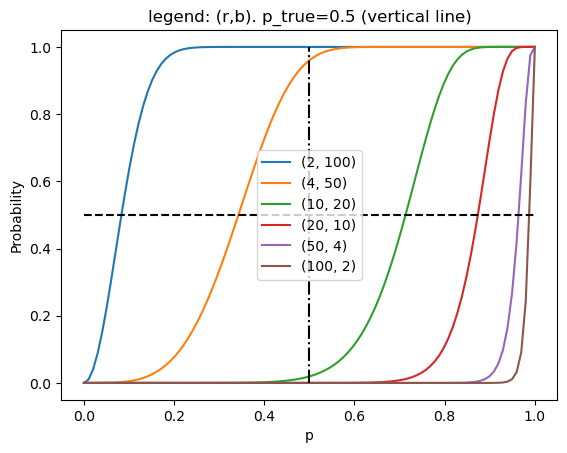

In [18]:
import matplotlib.pyplot as plt
n = 200
ops = [(2,100),(4,50),(10,20),(20,10),(50,4),(100,2)]
yval = lambda p,r,b: 1-(1-p**r)**b
pts = np.linspace(0,1,100)
for op in ops:
    plt.plot(pts, yval(pts,op[0],op[1]), label=op)
plt.hlines(0.5,0,1, linestyles ='dashed', colors ='k')
plt.vlines(0.5,0,1, linestyles ='-.', colors ='k')
plt.legend()
plt.xlabel('p')
plt.ylabel('Probability')
plt.title("legend: (r,b). p_true=0.5 (vertical line)")
plt.show()

> **Exercise 3-5:** Examine the curves in the plot and provide short . 
> 1. How does the position of the curve change with values of r and b for a fixed n and how does this change the optimal decision threshold?
> 2. How will the rate of true positives and false positives change with r and b? Hint, note how the steepness of the curve changes with r and b.    
> **End of exercise.**

> **Answers:**    
> 1. Increasing r (the number of rows per band) while decreasing b (the number of bands) shifts the curve to the right, vice versa decreasing r and increasing b shifts the curve to the left. This means the probability of a match increases sharply for higher similarity scores. This occurs because larger r values mean that more rows need to match within a band for the documents to be considered similar, which is stricter.
>
> Around p=0.5 should be optimal in decision threshold, if one creates a step function-like behavior where the decision boundary is sharp around the similarity score of 0.5, balancing finding true positives and potential false positives. This really also depends on the goal the user wants to achieve.

> 2. The rate of true positives increases when r is small and b is large, as the curve is positioned to catch more true pairs even with lower similarity scores p. This is seen in the steep, left-shifted curves (e.g.blue and orange curves). Yet, the rate of false positives also increases with small r and large b, as more pairs with lower similarity scores p are likely to be incorrectly considered matches. The trade-off here is between capturing all true positives and avoiding false positives.

### Finding optimal parameters

Consider the variables for the decision problem of determining which pairs of variables are similar:  
- $p$, the **crossover point** or **decision point**, values above p are considered similar.   
- $b$, the number of bands of the signature matrix.  
- $r$, the number of mini-hashes in each band.  
- $n$, the number of samples, with $n=br$.

For a fixed $n, p$ it is possible to solve for the optimal values r,b. Conversely of a fixed $n,r,b$ we can determine the crossover point $p$ for the decision, $p=f(b,r)$. Let's start with $p=1/2$.
$$1/2 = 1-(1-p^r)^b$$
$$ 1-p^r = 2^{-1/b}$$
$$p = (1-2^{-1/b})^{1/r} = (1-e^{-(1/b)\ln2})^{1/r} \approx (1/b)^{1/r}*\text{const}$$

If we fix $r$ and $p$, we can find the required number of bands to be about
$b \approx 1/p^r$

You have already scene how changing $r$ and $b$ for a fixed $n$ shifts the decision curve. The code in the cell below plots the decision function curve for several optimal values of $r,b$ with increasing $n$. The values of $r$ are considered optimal since the crossing point, $p=0.5, for each combination. Execute the code and examine the results.      

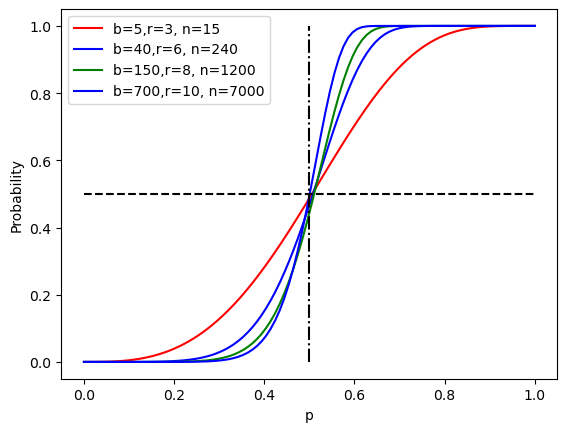

In [19]:
x = np.linspace(0,1,100) 
for b,r,col in [(5,3,'r'),(40,6,'b'),(150,8,'g'),(700,10,'b')]:
    y = 1-(1-x**r)**b
    plt.plot(x,y,c=col,label=f"b={b},r={r}, n={b*r}")
plt.hlines(0.5,0,1, linestyles ='dashed', colors ='k')
plt.vlines(0.5,0,1, linestyles ='-.', colors ='k')
plt.legend()
plt.xlabel('p')
plt.ylabel('Probability')

plt.legend()
plt.show()

> **Exercise 3-6:** Keeping in mind that a steeper curve is a better decision function, for optimal $r,b$, what do these curves tell you about the value of increasing $n$.    
> **End of exercise.** 

> **Answer:** 
> As n increases, the curves generally become steeper. This is because a higher number of mini-hashes allows for more precise estimation of similarity, reducing variance and improving the reliability of the similarity scores. However, increasing n improves the precision of the LSH algorithm but at the cost of increased compute.

### LSH with Banded Mini-Hash 

Let's try a simple example of banded mini-hashing. Specifically, the OR-AND method is applied to a banded signature matrix.       
The code in the cell below implements the algorithm is a straight-forward way. While not optimal in terms of computational complexity, the code is intended to make the algorithm clear. The functions provided are:    
1. `bandedCandidatePair`, is a function which first computes a logical array of matches between two columns, then divides that array into $b$ bands and determines if any of these bands are all true values, or all matches. The signature matrix is divided into bands using [numpy.array_split](https://numpy.org/doc/stable/reference/generated/numpy.array_split.html). 
2. `bandedCandidatePairs`, calls the bandedCandidatePair function for each combination of columns, and if that function returns a logical true (a match of at least one band) the keys for the pair are added to the pairs list.

Execute the code and examine the results.  

In [20]:
def bandedCandidatePair(col1, col2, b, r):
    """Returns a boolean if the two columns are a candidate pair
    inputs must obey n=len(col1)=len(col2)=b*r"""
    n = len(col1)
    assert(n==b*r)
    assert(n==len(col2))
    truth_array = (col1==col2)
    return any(all(band) for band in np.array_split(truth_array,b))

def bandedCandidatePairs(sig_mat, b, r):
    d = sig_mat.shape[1]
    idxs = range(d)
    cols = [sig_mat[:,i] for i in range(d)]
    pairs = set()
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs,cols),2):
        if bandedCandidatePair(col1,col2,b,r):
            pairs.add((i,j))
    return pairs

# set p = 0.3 arbitrarily
p = 0.25
n = 120
b = 20
r = 6

# see how many candidate pairs we got right!
np.random.seed(57988)
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)

print("\nPairs found by Jaccard similarity of all shingles:",candidatePairs(true_score_dict, p))
print("Pairs found with LSH:",bandedCandidatePairs(sig_mat, b, r))
print("Simple MinHash pairs:",candidatePairs(approx_score_dict, p))


Pairs found by Jaccard similarity of all shingles: {(0, 4), (3, 4), (1, 4)}
Pairs found with LSH: set()
Simple MinHash pairs: {(0, 2), (0, 4), (3, 4)}


> **Exercise 03-7:** Provide short answers to the following questions:    
> 1. Examine the code in the `return` statement of the `bandedCandidatePair` function. Explain why this code implements the OR-AND construction algorithm.  
> 2. Compare the candidate pairs found by the three methods. Given the composition of document 4 which errors are made in terms of false positive and false negative by each of the methods, and what does this result tell you about their respective accuracies? 

> **Answers:** 
> 1. This is seen in any(all(band) for ...)
>
>    OR Condition (any): The function returns True if at least one band matches completely.
>
>    AND Condition (all): A band is considered a match if all the values in that band are equal between the two columns. 
>
> 
> 2. Jaccard similarity: no false negatives and found all pairs, represents ground truth.
>
>    LSH: missing all pairs, so 3 false negatives
>
>    Simple MinHash: 1 false positives (0,2), 1 false negative (1,4) not found.
>
>    This tells me that LSH is overly conservative and does not find the correct pairs but also did not generate any false positives, while simple MinHash is only somewhat accurate with both false positive and negatives. Jaccard similarity is obviously the most accurate of the three.

### Efficient LSH algorithm  

The banded OR-AND mini-hashing has produced better results than simple mini-hashing. However, the algorithm used required matching $\frac{n(n-1)}{2}$ or $\mathcal{O}(n^2)$ matching operations. Clever use of a hash table allows us to create an equivalent algorithm with  $\mathcal{O}(n)$ time complexity.   

The code in the cell below uses a hash table constructed with a [collections.defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) to match candidate pairs. Execute the code and examine the results.   

In [21]:
def fastCandidatePairs(sig_mat, b, r):
    n, d = sig_mat.shape
    assert(n==b*r)
    hashbuckets = collections.defaultdict(set)
    bands = np.array_split(sig_mat, b, axis=0)
    for i,band in enumerate(bands):
        for j in range(d):
            # The last value must be made a string, to prevent accidental
            # key collisions of r+1 integers when we really only want
            # keys of r integers plus a band index
            band_id = tuple(list(band[:,j])+[str(i)])
            hashbuckets[band_id].add(j)
    candidate_pairs = set()
    for bucket in hashbuckets.values():
        if len(bucket) > 1:
            for pair in itertools.combinations(bucket, 2):
                candidate_pairs.add(pair)
    return candidate_pairs


#p = 0.30
p = 0.25
n = 120
b = 20
r = 6

# see how many candidate pairs we got right!
np.random.seed(1267)
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print('True pairs:\t', candidatePairs(true_score_dict, p))
print("LSH pairs:\t", bandedCandidatePairs(sig_mat, b, r))
print("Fast LSH pairs:\t", fastCandidatePairs(sig_mat, b, r))
print("MinHash pairs:\t", candidatePairs(approx_score_dict, p))

True pairs:	 {(0, 4), (3, 4), (1, 4)}
LSH pairs:	 set()
Fast LSH pairs:	 set()
MinHash pairs:	 {(0, 4), (3, 4), (1, 4)}


> **Exercise 03-8:** Examine the `fastCandidatePairs` function. Explain why this algorithm is equivalent to the OR-AND construction examined for Exercise 03-6, but yet can run in $O(n)$ time.    
> **End of Exercise.**

> **Answer:**  The fastCandidatePairs function achieves the same as OR-AND by hashing documents into buckets based on bands. If all elements in a band match, documents hash to the same bucket. If multiple documents hash to the same bucket, they are considered candidate pairs. Thus, fastCandidatePairs implements the same logic: documents are compared band-by-band (AND within bands) and only need to match in one band to be considered a candidate pair (OR across bands).
>
> Improved efficiency is due to the use of hash tables, inserting each document's band into a hash table is an O(1) operation, making the entire hashing process 
O(n) for all documents.   

> **Exercise 03-9:** The LSH and fast LSH algorithms both make the same error in this case. Is there an efficient way to improve on this result? Yes. We can take advantage of the fact that most similar pairs hash to the same bucket, we can do the following:    
> 1. Find the full Jacard similarities of only the pairs in the bucket. The limited number of pairs candidates makes this calculation efficient.    
> 2. Filter the full Jarard similarities by a threshold.       
> Examine and execute the code in the cell below.   

In [24]:
pair_labels = []
pair_sims = []
for x1, x2 in bandedCandidatePairs(sig_mat, b, r):
    pair_labels.append((x1,x2))
    pair_sims.append(jaccardSim(doc_shingles[x1],doc_shingles[x2]))
    
print('The similaritiy of the pairs in the bucket = ' + str(np.round(pair_sims, 3)))
threshold = 0.25
print(f"**True similarity scores**")
print("Pair\tScore")
print("-"*14)
for pair, score in zip(pair_labels, pair_sims):
    if score > threshold: print(f"{pair}\t{score:.3f}")

The similaritiy of the pairs in the bucket = []
**True similarity scores**
Pair	Score
--------------


> This simple algorithm has filtered out false positive errors. Explain why this approach is compuationally efficeint compare to testing pairwise similarities.  

> **Answer:**     For some reason my LSH algorithms did not yield any pairs, and I understand this code is intended to filter out false positives, so I the answer is in theory and not directly confirmed by the output.
>
> The bandedCandidatePairs function quickly identifies pairs of documents that are likely to be similar by hashing their signature matrices into buckets. Only pairs that fall into the same bucket are considered candidate pairs.  Instead of comparing every possible pair, which would be computationally expensive (O(n^2)), LSH narrows it down to a much smaller subset of likely candidates with approx. (O(n)). Then, only the pairs identified by the LSH step are further evaluated using the full Jaccard similarity and filtered by threshold, which should be linear in complexity with respect to number of candidate pairs. Overall the algorithm filters out false positives while also increasing computational efficiency.

#### Copywrite 2022, 2023, 2024 Stephen F Elston. All rights reserved.  